## Timbre Transfer for Audio Generation

In this notebook we are going to use [RAVE](https://github.com/acids-ircam/RAVE) - a Realtime Audio Variational Autoencoder to generate sound. You can read the respective paper [here](https://arxiv.org/abs/2111.05011). 

RAVE is a very light model that allows for generating audio in real-time in the CPU. However, note that we will be using pre-trained models, navigating in their latent space and generating audio from them. More specifically, we will be performing timbre transfer, which is the process of passing in the encoder an existing audio file and expecting the decoder export an audio file with an altered timbre. This notebook is not about training a new RAVE model, which is very a computationally demanding process.

This notebook is adapted from Iran R. Roman (iran [@] ccrma.stanford.edu) and [Teresa Pelinski](https://teresapelinski.com).


Possibly needed installs:

In [ ]:
# !conda install conda-forge::librosa -y

#### Imports

In [8]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import librosa as li
import soundfile as sf
import numpy as np
import requests
import torch
import os

##### Load a sample audio file

You will find a few sound files in the `sounds` folder. Feel free to populate it with more. You can look into [freesound.org](https://freesound.org). 

In the code cell below, we download an audio sample instead from [here](https://ccrma.stanford.edu/~jos/pasp/Sound_Examples.html). You can also select another audio sample from this url.

In [9]:
# download a sample audio file
def download_file(url, file_path):
    """
    Download file from a given URL and save it to the specified file path
    """
    response = requests.get(url)
    response.raise_for_status()  # this will raise an exception if there is an error
    with open(file_path, 'wb') as file:
        file.write(response.content)
        
url = 'https://ccrma.stanford.edu/~jos/wav/gtr-nylon22.wav'
audio_path = './sounds/audio-sample.wav'
download_file(url, audio_path)

input_data, sample_rate = li.load(audio_path)
display(Audio(input_data, rate=sample_rate))

##### Visualise the audiowave

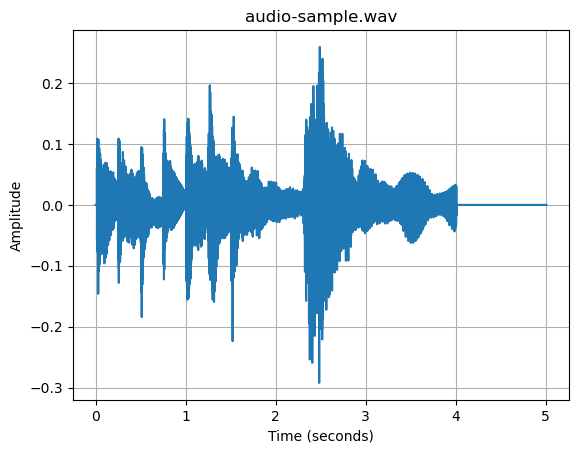

In [10]:
time = np.arange(0, len(input_data)) / sample_rate # to obtain the time in seconds, we need to divide the sample index by the sample rate
plt.plot(time, input_data)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(audio_path.split("/")[-1])
plt.grid()

##### Download one or more pre-trained models

In [11]:
# Download rave parameters/weights and build the model
url = 'https://play.forum.ircam.fr/rave-vst-api/get_model/percussion'
# url = 'https://play.forum.ircam.fr/rave-vst-api/get_model/vintage'
# url = 'https://play.forum.ircam.fr/rave-vst-api/get_model/nasa'
# url = 'https://play.forum.ircam.fr/rave-vst-api/get_model/darbouka_onnx'
# url = 'https://play.forum.ircam.fr/rave-vst-api/get_model/VCTK'
# you can learn more about each model at:
# https://acids-ircam.github.io/rave_models_download

# Automatically fetches model name from url:
# model_path = os.path.join('./models', os.path.basename(url) + '.ts')
# download_file(url, model_path)

# If you already have the model file, you can skip the code above and load it directly:
model_path = './models/percussion.ts'

torch.set_grad_enabled(False)
model = torch.jit.load(model_path).eval()

##### Perform timbre transfer on the sample audio file

We loaded a pretrained model using `torch.jit.load` and we can now encode an input audio into a latent representation. For the percussion model, we will be encoding our input audio into a latent space trained on 8h of various percussion recordings. We can then decode the latent representation and synthesise it. This will make the original sound as if it was percussion (timbre transfer).

In [ ]:
input_data, sample_rate = li.load(audio_path)
input_data = torch.from_numpy(input_data).reshape(1, 1, -1)
# where 1 is the batch size and 1 is the number of channels
# -1 is the length of the signal, which is inferred from the input data

# encode and decode the audio with RAVE
# to synthesise audio from latent representation
z = model.encode(input_data) # encode the signal into the latent representation
y = model.decode(z).numpy() # decode latent representation and convert tensor to numpy array
y = y[:,0,:].reshape(-1) # remove batch and channel dimensions

# sf.write("model_output.wav", y, sample_rate) # to save the file
display(Audio(y, rate=sample_rate))

Different RAVE models have different latent dimensions (e.g., 4, 8, 16, etc.) based on the training dataset and task.

The percussions one apparently has 4:

In [ ]:
z.shape, y.shape
# ([batch, dimentions, length]) , (length,)

(torch.Size([1, 4, 54]), (110592,))

##### Perform timbre transfer on randomness

Sample random points in the latent space and generate sound clips out of them. Then, concantenate them all into a continuous clip.

In [16]:
latent_dim = 8

generated_clips = []
for i in range(100):
    # randomly sample latent space
    z = torch.randn(1,latent_dim,1)
    
    # generate audio clip and append to list
    gen_audio_clip = model.decode(z)
    gen_audio_clip = gen_audio_clip.reshape(-1).cpu().numpy()
    generated_clips.append(gen_audio_clip)

# concantenate list of audio clips into one array
y = np.concatenate(generated_clips)
# sf.write("random_output.wav", y, sample_rate) # to save the file
display(Audio(y, rate=sample_rate)) # display audio widget

In [18]:
z.shape

torch.Size([1, 8, 1])

##### Altering latent representations

Modify the latent coordinates of the input file to alter the representation. We can start by adding a constant bias (a displacement) to the coordinates in the latent space. 

Note that each RAVE model has a different number of coordinates for its latent space.

In [ ]:
input_data, sample_rate = li.load(audio_path)
x = torch.from_numpy(input_data).reshape(1, 1, -1)

z = model.encode(x) # encode the signal into the latent representation

z_modified = torch.clone(z) # copy latent representation

d0 = 2.0  # change that will occur in latent dimension 0
d1 = 1.2 
d2 = 0.05
d3 = 0.8
# you can add and play with more of the available dimensions

z_modified[:, 0] += torch.linspace(-d0, d0, z.shape[-1])
z_modified[:, 1] += torch.linspace(-d1,d1, z.shape[-1])
z_modified[:, 2] += torch.linspace(-d2,d2, z.shape[-1])
z_modified[:, 3] += torch.linspace(-d3,d3, z.shape[-1])

y = model.decode(z_modified).numpy().reshape(-1)
# sf.write("latent_output.wav", y, sample_rate) # save output audio
display(Audio(y, rate=sample_rate))


##### Now move to MAX

Move into the MAX patch `rave-in-max` and find the analogies between what we just did in the last cell and what is happening there.